## Charger ton modèle final et les données

In [5]:
import joblib
import pandas as pd

pipeline = joblib.load("../model/xgboost_pipeline.pkl")
df = pd.read_csv("../data/processed/train_clean.csv")

X = df.drop("SeriousDlqin2yrs", axis=1)
y = df["SeriousDlqin2yrs"]


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Évaluation des performances du modèle

#### Classification complète

In [7]:
from sklearn.metrics import classification_report

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.62      0.18      0.27      2005

    accuracy                           0.94     30000
   macro avg       0.78      0.58      0.62     30000
weighted avg       0.92      0.94      0.92     30000



#### AUC, F1, Confusion Matrix

In [8]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

y_proba = pipeline.predict_proba(X_test)[:, 1]
print("AUC :", roc_auc_score(y_test, y_proba))
print("F1-score :", f1_score(y_test, y_pred))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))


AUC : 0.8689050903728356
F1-score : 0.2732919254658385
Matrice de confusion :
 [[27776   219]
 [ 1653   352]]


#### Courbe ROC + courbe de précision-rappel

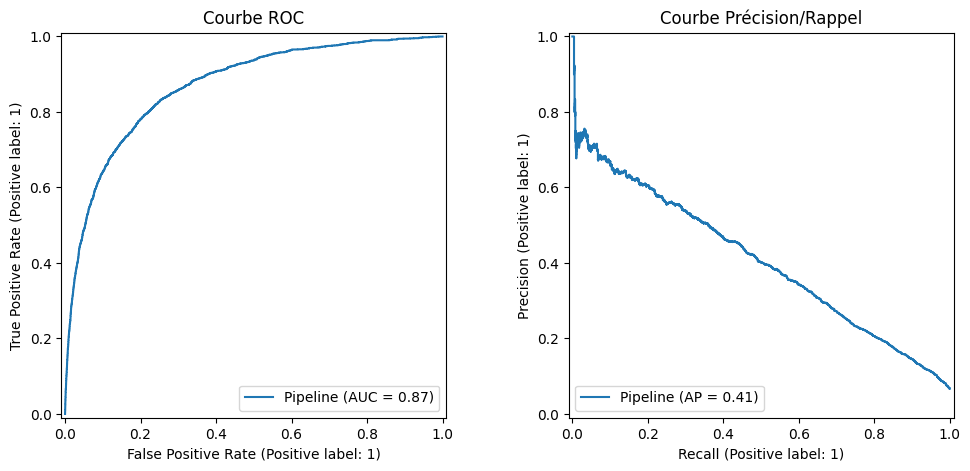

In [9]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=axs[0])
axs[0].set_title("Courbe ROC")

PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test, ax=axs[1])
axs[1].set_title("Courbe Précision/Rappel")

plt.show()

#### Précision & Rappel en fonction du seuil

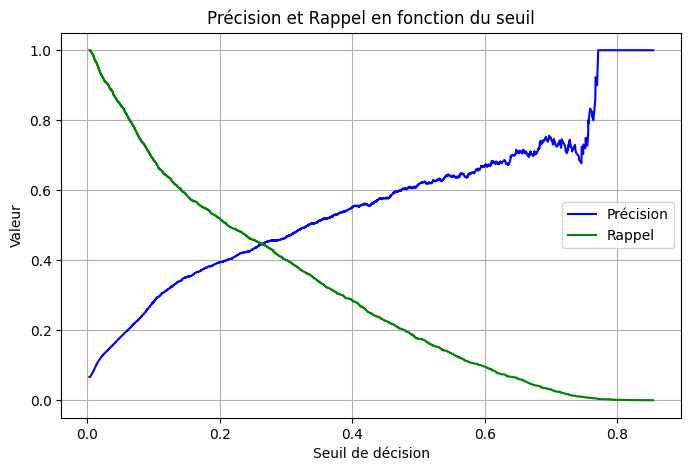

In [10]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Probabilités prédites pour la classe 1 (défaut)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Calcul des valeurs
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Tracé
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label="Précision", color="blue")
plt.plot(thresholds, recalls[:-1], label="Rappel", color="green")
plt.xlabel("Seuil de décision")
plt.ylabel("Valeur")
plt.title("Précision et Rappel en fonction du seuil")
plt.legend()
plt.grid(True)
plt.show()


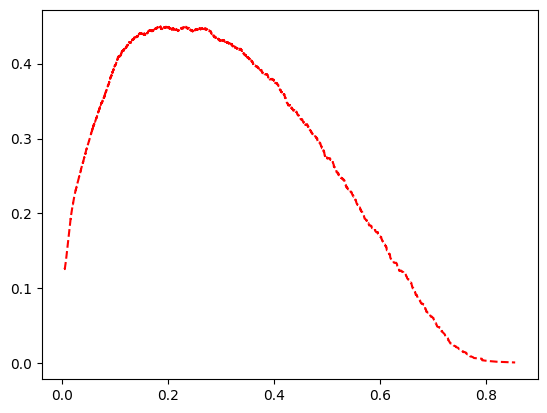

In [11]:
from sklearn.metrics import f1_score
import numpy as np

f1_scores = [f1_score(y_test, y_proba >= t) for t in thresholds]

plt.plot(thresholds, f1_scores, label="F1-score", color="red", linestyle="--")


# Analyse SHAP

#### Extraction du modèle et les features transformées

In [12]:
model = pipeline.named_steps["classifier"]
preprocessor = pipeline.named_steps["preprocessor"]
X_test_transformed = preprocessor.transform(X_test)

In [13]:
feature_names = X_test.columns.tolist()

#### l'explainer et calculer les valeurs SHAP

In [14]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_transformed)

/Users/davidamouzou/codex/credit-default-prediction/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Visualisation de l’importance globale

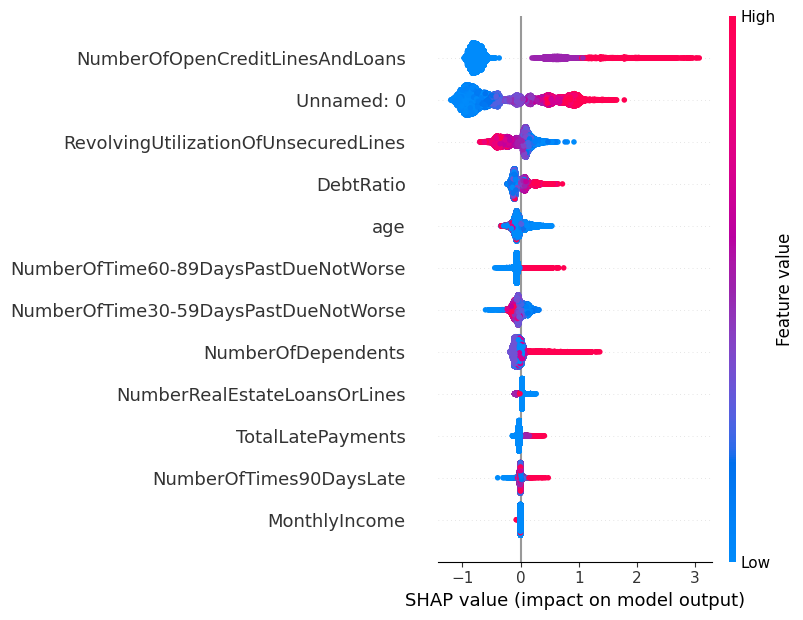

In [15]:
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

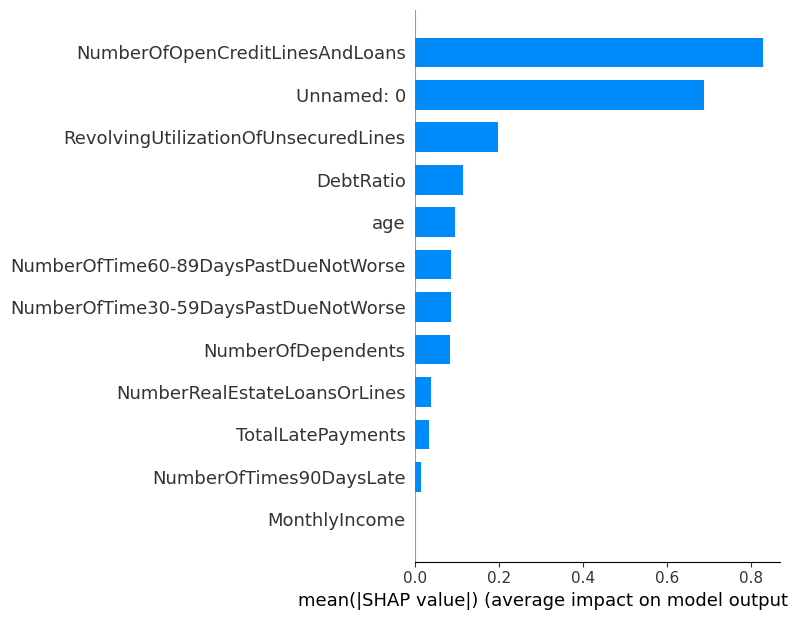

In [16]:
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="bar")